# Tutorial - Text Mining - Classification 

### ISM6564

**Week04, Part02**

&copy; 2023 Dr. Tim Smith

<a target="_blank" href="https://colab.research.google.com/github/prof-tcsmith/ta-f23/blob/main/W04/4.2-Tutorial - predictive modeling in text mining - classification.ipynb#offline=1">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

---

## Introduction


We will predict the category of discussion posts in a newsgroup based on the text of the post. We will use the 20 Newsgroups dataset, which contains around 18,000 newsgroups posts on 20 topics. The dataset is available in scikit-learn. We will use the following categories:



### Import common packages

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import tools to pre-process the text data
from sklearn import preprocessing

# Extracting features from text files
#   SciKit Learn includes a number of useful feature extraction classes 
#   https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction.text
# 
#   We will use TfidfVectorizer (which includes pre-processing, tokenization, and filtering out stop words)
from sklearn.feature_extraction.text import TfidfVectorizer

# import tools to reduce the dimensionality of the data
from sklearn.decomposition import TruncatedSVD

# import tools to split the data into training and test sets
from sklearn.model_selection import train_test_split

# import ML classifiers we will use to model the data
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neural_network import MLPClassifier

# import tools to evaluate the model performance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

# set the seed for numpy
np.random.seed(42)
# Set the seed for the built-in Python random number generator
#random.seed(42)

### Load data

In [47]:
news = pd.read_csv('./data/news.csv')

news.shape

(597, 5)

In [48]:
news.sample(n=20)

,TEXT,graphics,hockey,medical,newsgroup
109,"Hi, netters I am looking for source code that ...",1,0,0,graphics
480,In article < 1993Mar24.182145.11004@equator.co...,0,0,1,medical
135,Our group recently bought a Mitsubishi P78U vi...,1,0,0,graphics
77,I'm interested in find out what is involved in...,1,0,0,graphics
396,In article < saross01.734885336@starbase.spd.l...,0,1,0,hockey
286,I think that NHLPA' 93 is the best video game ...,0,1,0,hockey
10,"In article < 1pp991$t63@cc.tut.fi> , jk87377@l...",1,0,0,graphics
589,In article < C5JDuo.K13@unx.sas.com> sasghm@th...,0,0,1,medical
78,Robert J.C. Kyanko (rob@rjck.UUCP) wrote: Do y...,1,0,0,graphics
416,A friend of mine has a trouble with her ears r...,0,0,1,medical


### Check for missing values

In [49]:
count = news['TEXT'].isna().sum()
if  count > 0:
    print(f'Found {count} null values in TEXT column')
    #news['newsgroup'].fillna('missing', inplace=True) # though we could do this, we will drop the rows instead - as there is no way to impute the text
    news = news.dropna(subset=['TEXT'])

In [50]:
count = news['newsgroup'].isna().sum()
if count  > 0:
    print(f'Found {count} null values in newsgroup column. Addressing this by filling with "missing"')
    #news['newsgroup'].fillna('missing', inplace=True) # though we could do this, we will drop the rows instead - we only have text and the newgroup as data, missing one doesn't leave much to model
    news = news.dropna(subset=['newsgroup'])

In [51]:
news['newsgroup'].unique()

array(['graphics', 'hockey', 'medical'], dtype=object)

## Assign the input variable to X and the target variable to y

In [52]:
X = news['TEXT']

This is a multi-class classification problem. There are three categories we will predict:<br>
Whether a post is "graphics," "hockey," or "medical" related

In [53]:
y = news['newsgroup']

In [54]:
le = preprocessing.LabelEncoder()  ## label encoding to y variable
le.fit(y)
classes = list(enumerate(le.classes_))
print(classes)
y = le.transform(y)

y

[(0, 'graphics'), (1, 'hockey'), (2, 'medical')]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

## Split the data

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [56]:
X_train.shape, y_train.shape

((417,), (417,))

In [57]:
X_test.shape, y_test.shape

((180,), (180,))

In [58]:
y_train

array([0, 1, 2, 1, 0, 0, 1, 1, 1, 2, 2, 2, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0,
       2, 2, 2, 0, 1, 0, 0, 1, 1, 1, 2, 2, 0, 2, 1, 1, 0, 2, 2, 2, 0, 1,
       0, 1, 1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0,
       1, 2, 0, 2, 2, 0, 0, 2, 1, 2, 1, 0, 2, 2, 2, 2, 0, 0, 2, 2, 1, 1,
       1, 1, 2, 1, 2, 0, 1, 0, 0, 1, 2, 0, 2, 0, 1, 0, 1, 1, 2, 2, 2, 2,
       2, 0, 2, 1, 1, 1, 1, 0, 0, 0, 1, 2, 1, 1, 2, 0, 1, 1, 0, 2, 2, 0,
       2, 0, 2, 1, 1, 0, 1, 0, 1, 0, 0, 2, 1, 0, 2, 1, 2, 0, 2, 1, 2, 1,
       2, 2, 2, 1, 2, 1, 0, 1, 2, 0, 2, 1, 1, 2, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 2, 2, 1, 0, 0, 1, 0, 2, 0, 1, 2, 2, 2, 1, 2, 0, 1, 1, 2, 0, 0,
       1, 2, 0, 2, 0, 1, 0, 1, 0, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 0,
       0, 0, 2, 2, 2, 1, 2, 1, 0, 2, 1, 2, 1, 1, 1, 0, 1, 1, 1, 2, 0, 0,
       1, 0, 2, 0, 0, 2, 0, 1, 2, 1, 1, 2, 0, 2, 1, 0, 0, 2, 0, 1, 2, 0,
       0, 2, 2, 2, 0, 1, 2, 0, 1, 2, 1, 0, 0, 0, 2, 2, 1, 1, 2, 2, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 2, 1, 1, 1,

## Sklearn: Text preparation

For simplicity (and focus), we will not do any text cleaning or preprocessing. We will just use the raw text as input to the model. See the text mining data prep tutorial for more details on text cleaning and preprocessing.

In [59]:
tfidf_vect = TfidfVectorizer() # see: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

X_train = tfidf_vect.fit_transform(X_train)

In [60]:
X_train.shape

(417, 11582)

In [61]:
X_train

<417x11582 sparse matrix of type '<class 'numpy.float64'>'
	with 43813 stored elements in Compressed Sparse Row format>

In [62]:
print(y_train)

[0 1 2 1 0 0 1 1 1 2 2 2 0 1 0 0 0 2 0 0 0 0 2 2 2 0 1 0 0 1 1 1 2 2 0 2 1
 1 0 2 2 2 0 1 0 1 1 2 2 0 2 2 2 1 2 2 1 1 0 2 0 0 0 0 0 0 1 2 0 2 2 0 0 2
 1 2 1 0 2 2 2 2 0 0 2 2 1 1 1 1 2 1 2 0 1 0 0 1 2 0 2 0 1 0 1 1 2 2 2 2 2
 0 2 1 1 1 1 0 0 0 1 2 1 1 2 0 1 1 0 2 2 0 2 0 2 1 1 0 1 0 1 0 0 2 1 0 2 1
 2 0 2 1 2 1 2 2 2 1 2 1 0 1 2 0 2 1 1 2 0 0 0 0 1 1 0 1 1 2 2 1 0 0 1 0 2
 0 1 2 2 2 1 2 0 1 1 2 0 0 1 2 0 2 0 1 0 1 0 1 1 1 1 2 1 2 2 1 1 2 2 0 0 0
 2 2 2 1 2 1 0 2 1 2 1 1 1 0 1 1 1 2 0 0 1 0 2 0 0 2 0 1 2 1 1 2 0 2 1 0 0
 2 0 1 2 0 0 2 2 2 0 1 2 0 1 2 1 0 0 0 2 2 1 1 2 2 0 1 1 1 0 1 1 0 0 1 1 0
 0 2 1 1 1 1 0 2 2 1 0 1 1 0 1 2 0 0 1 2 1 2 2 1 2 1 0 2 2 2 0 1 0 1 2 0 0
 1 0 2 0 0 2 2 1 1 0 2 1 1 2 2 0 2 1 1 0 2 2 2 1 1 1 1 0 0 2 2 0 0 2 1 2 0
 2 0 1 1 0 1 2 2 0 1 0 2 0 0 2 0 0 0 2 2 1 0 0 1 1 1 2 2 1 1 2 1 2 0 0 2 0
 1 0 0 0 2 1 1 2 0 0]


**Notice in the previous step that we use `fit_transform` on TRAIN. When we transform the TEXT data, we need to use `transform` only. This enables us to keep the number of columns (features) the same across the data sets. Otherwise, they WILL be different, and no model will work!**

In [63]:
# Perform the TfidfVectorizer transformation
# Be careful: We are using the train fit to transform the test data set. Otherwise, the test data 
# features will be very different and match the train set!!!

X_test = tfidf_vect.transform(X_test)

In [64]:
X_train.shape, X_test.shape

((417, 11582), (180, 11582))

In [65]:
# These data sets are "sparse matrix". We can't see them unless we convert using toarray()
X_train

<417x11582 sparse matrix of type '<class 'numpy.float64'>'
	with 43813 stored elements in Compressed Sparse Row format>

In [66]:
# These data sets are "sparse matrix". We can't see them unless we convert using toarray()
np.set_printoptions(precision=3)
print(X_train.todense())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Latent Semantic Analysis (Singular Value Decomposition)

In [67]:
svd = TruncatedSVD(n_components=300, n_iter=10) #n_components is the number of topics, which should be less than the number of features, and number of rows in the matrix

X_train_dim_reduct = svd.fit_transform(X_train)
X_test__dim_reduct = svd.transform(X_test)

In [68]:
X_train.shape, X_test.shape

((417, 11582), (180, 11582))

In [69]:
X_train_dim_reduct.shape, X_test__dim_reduct.shape

((417, 300), (180, 300))

## Random Forest

In [70]:
%%time

rf_clf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=10, n_jobs=-1).fit(X_train, y_train)

CPU times: total: 31.2 ms
Wall time: 131 ms


In [71]:
%time

y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)

CPU times: total: 0 ns
Wall time: 0 ns


In [72]:
print(f"Train accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

Train accuracy: 0.9185
Test accuracy: 0.8500


In [74]:
type(y_train)

numpy.ndarray

In [28]:
confusion_matrix(y_test, y_test_pred)

array([[52,  2,  5],
       [ 2, 58,  0],
       [14,  4, 43]], dtype=int64)

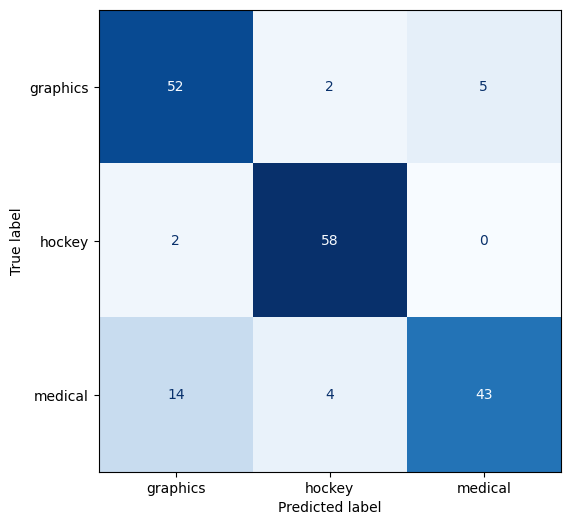

In [29]:
# display the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_, colorbar=False)
fig, ax = plt.subplots(figsize=(8, 6))
#ConfusionMatrixDisplay.from_estimator(
#    rnd_clf, X_test, y_test, display_labels=le.classes_, ax=ax, colorbar=False, cmap=plt.cm.Blues
#)
ConfusionMatrixDisplay.from_predictions(
    y_test, y_test_pred, display_labels=le.classes_, ax=ax, colorbar=False, cmap=plt.cm.Blues
)
plt.show()


## Stochastic Gradient Descent Classifier

In [30]:
%%time

sgd_clf = SGDClassifier(max_iter=150, n_jobs=-1).fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 10 ms


In [31]:
%%time

y_train_pred = sgd_clf.predict(X_train)
y_test_pred = sgd_clf.predict(X_test)

CPU times: total: 0 ns
Wall time: 1.95 ms


In [32]:
print(f"Train accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

Train accuracy: 0.9952
Test accuracy: 0.9111


In [33]:
confusion_matrix(y_test, y_test_pred)

array([[52,  1,  6],
       [ 2, 58,  0],
       [ 7,  0, 54]], dtype=int64)

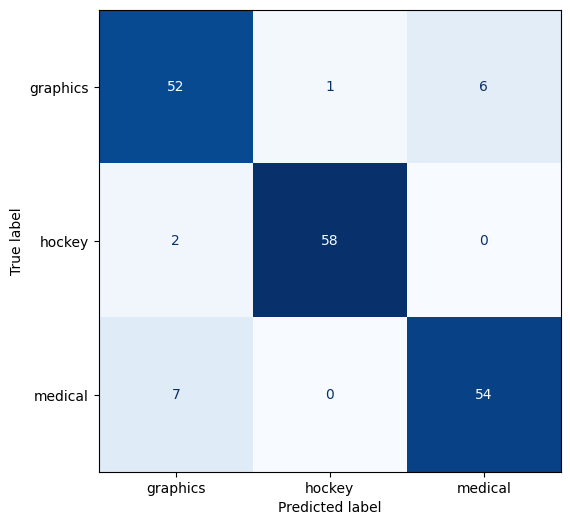

In [34]:
# display the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_test_pred, display_labels=le.classes_, ax=ax, colorbar=False, cmap=plt.cm.Blues
)
plt.show()

## ANN Classifier

In [1]:
%time

ann_clf = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=400).fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


NameError: name 'MLPClassifier' is not defined

In [36]:
%time

y_train_pred = ann_clf.predict(X_train)
y_test_pred = ann_clf.predict(X_test)


CPU times: total: 0 ns
Wall time: 0 ns


In [37]:
print(f"Train accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

Train accuracy: 0.9952
Test accuracy: 0.9500


In [38]:
confusion_matrix(y_test, y_test_pred)

array([[51,  1,  7],
       [ 0, 60,  0],
       [ 1,  0, 60]], dtype=int64)

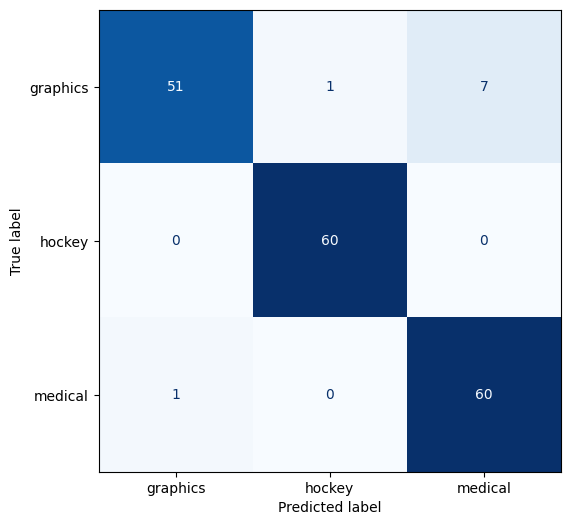

In [39]:
# display the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_test_pred, display_labels=le.classes_, ax=ax, colorbar=False, cmap=plt.cm.Blues
)
plt.show()